# In this notebook I'll implement and test an Pegasos-Svm implementation

papaer: http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf

In [2]:
import numpy as np
from sklearn.metrics import accuracy_score 

In [4]:
class PegasosSVM:
    def __init__(self, lam, T):
        self.lam = lam
        self.T = T
        self.W = None

    def fit(self, X, y):
        self.W = np.zeros((self.T + 1, X.shape[1]))
        for t in range(0,self.T):
            ith = np.random.randint(0,X.shape[0])
            lr = 1.0 / (self.lam * (t+1))
            w = self.W[t]
            dot = w @ X[ith]
            if y[ith] * dot < 1:
                self.W[t + 1] = (1 - (lr * self.lam)) * w + lr * y[ith] * X[ith]
            else:
                self.W[t + 1] = (1 - (lr * self.lam)) * w
        return self.W[-1]
    
    def predict(self, X):
        ret = []
        for x in range(0, X.shape[0]):
            if self.W[-1] @ X[x] >= 0:
                ret.append(1)
            else:
                ret.append(-1)
        return np.array(ret)

    def decision_function(self, X, y):
        return y * np.dot(self.W, X)
    
    def score_error(self, X, y):
        pred = self.predict(X)
        return (np.sum(((pred - y)/ 2.0)**2)) / y.shape[0]

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

    def get_params(self, deep=False):
        return {"T": self.T, "lam":self.lam}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

### Now lets test our implemetation on the breat-cancer dataset, and we will compare this implementation with the native scikit-learn one

#### First lets load the data and scale it accordingly

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()

X, y = load_breast_cancer(return_X_y=True)
X_scaled = scaler.fit_transform(X)

y[y==0] = -1

X = np.c_[X_scaled, np.ones(X_scaled.shape[0])]

#### **I'll start by calcualting pegasos-svm accuracy using corss val score**

In [6]:
pega = PegasosSVM(0.001, 100000)
print(cross_val_score(pega, X, y, cv=5))

[0.95614035 0.95614035 0.97368421 0.97368421 0.99115044]


#### Now lets calcualte the native svm (LinearSVC) accuracy

In [7]:
from sklearn.svm import LinearSVC
clf = LinearSVC(max_iter=100000)
cvs = cross_val_score(clf, X, y, cv=5)
print("------------------------------------------------")
print("Scikit Native SVM Cross-Val-Score : " +str(cvs))
print("------------------------------------------------")

------------------------------------------------
Scikit Native SVM Cross-Val-Score : [0.94736842 0.95614035 0.95614035 0.98245614 0.99115044]
------------------------------------------------


#### Lets analyze the effect of $\lambda$

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

In [9]:
def Vald_Curve(estimator):
    lw = 2
    param_range = np.array([0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.5])
    train_scores, test_scores = validation_curve(
        estimator, 
        X, 
        y, 
        param_name="lam",
        param_range=param_range,
        scoring="accuracy", 
        n_jobs=1,
        cv=5)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    plt.title("Validation Curve with Pegasos-SVM")
    plt.xlabel(r"$\lambda$")
    plt.ylabel("Score")
    
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

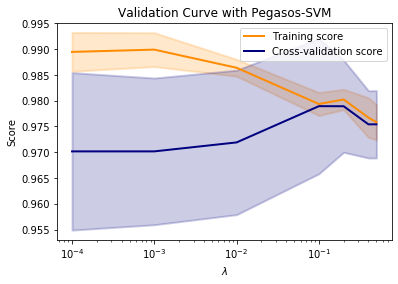

In [10]:
Vald_Curve(PegasosSVM(0.001, 100000))

#### Lets analyze the learning curve - meaning the performance as a function of the training size

In [13]:
from sklearn.model_selection import learning_curve

In [14]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

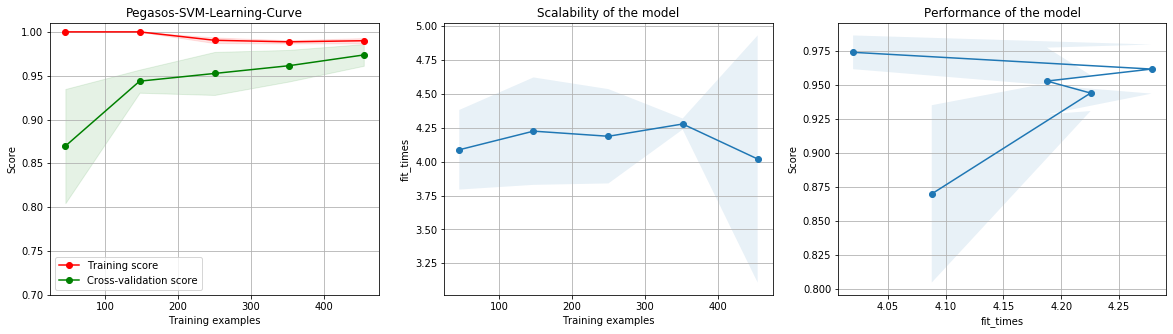

In [15]:
# fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Pegasos-SVM-Learning-Curve"
estimator = PegasosSVM(0.001, 100000)
plot_learning_curve(estimator, title, X, y, axes=None, ylim=(0.7, 1.01),
                    cv=5, n_jobs=4)

plt.show()